# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Download the data

<class 'str'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
Saving figure attribute_histogram_plots


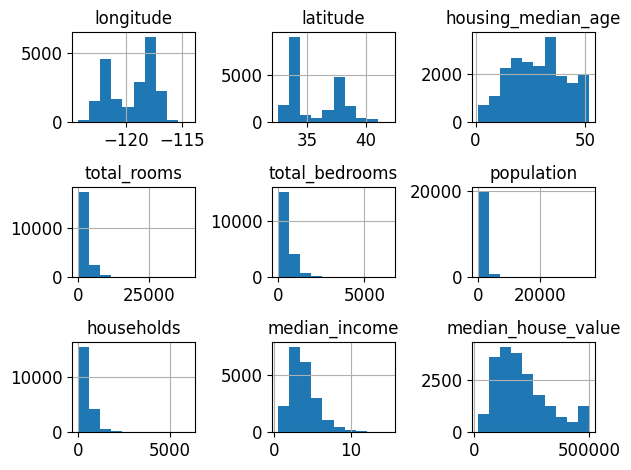

In [4]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
print(type(HOUSING_PATH))
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
fetch_housing_data()
housing = load_housing_data()
housing.head()
housing.info()
housing["ocean_proximity"].value_counts()
housing.describe()

import matplotlib.pyplot as plt
# bins=50, figsize=(20,15)
housing.hist()
save_fig("attribute_histogram_plots")
plt.show()

# Create a Test Set

<AxesSubplot: >

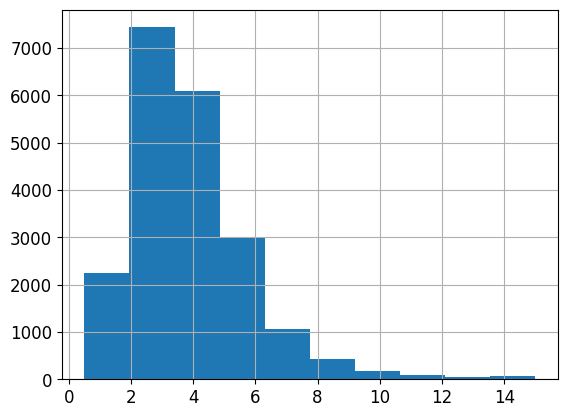

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()
housing["median_income"].hist()

# stratified sampling

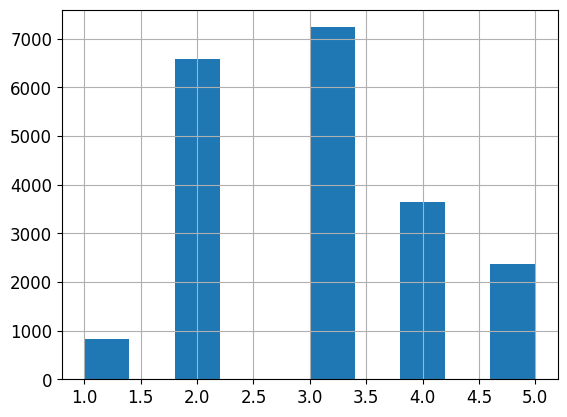

In [6]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()
housing["income_cat"].hist()

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# split the original data using the "income_cat" attribute
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set
# remove "income_cat" attribute, we don't need it anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

Saving figure housing_prices_scatterplot


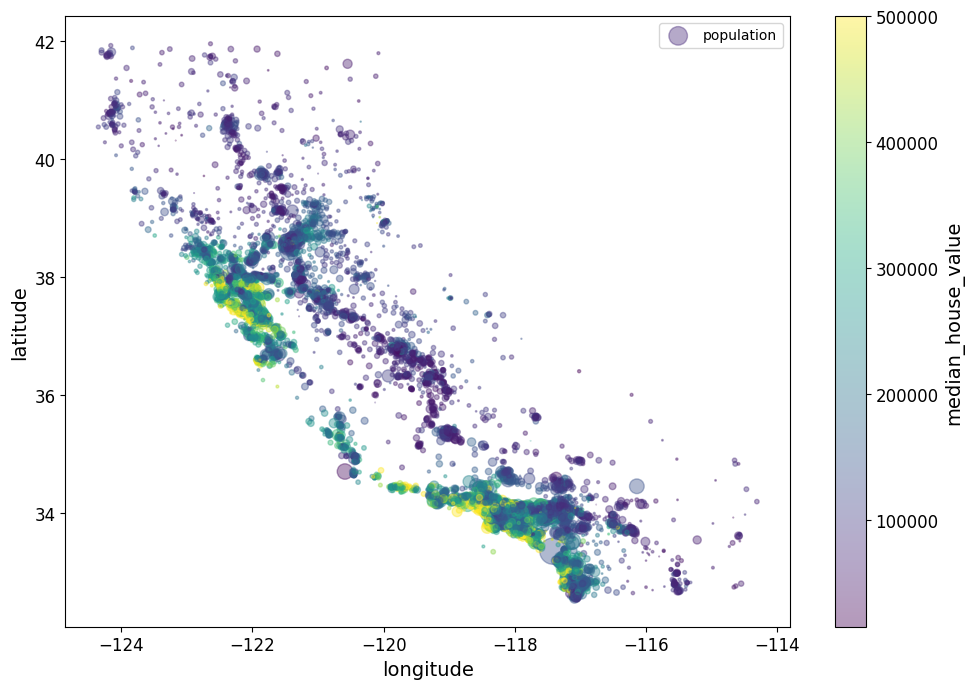

In [7]:
housing = strat_train_set.copy()
# housing.plot(kind="scatter", x="longitude", y="latitude")
# save_fig("bad_visualization_plot")
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
# save_fig("better_visualization_plot")

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", colorbar=True,
             sharex=False)
# cmap=plt.get_cmap("jet")
plt.legend()
save_fig("housing_prices_scatterplot")

# Looking for Correlations

we can use pandas scatter matrix

Saving figure scatter_matrix


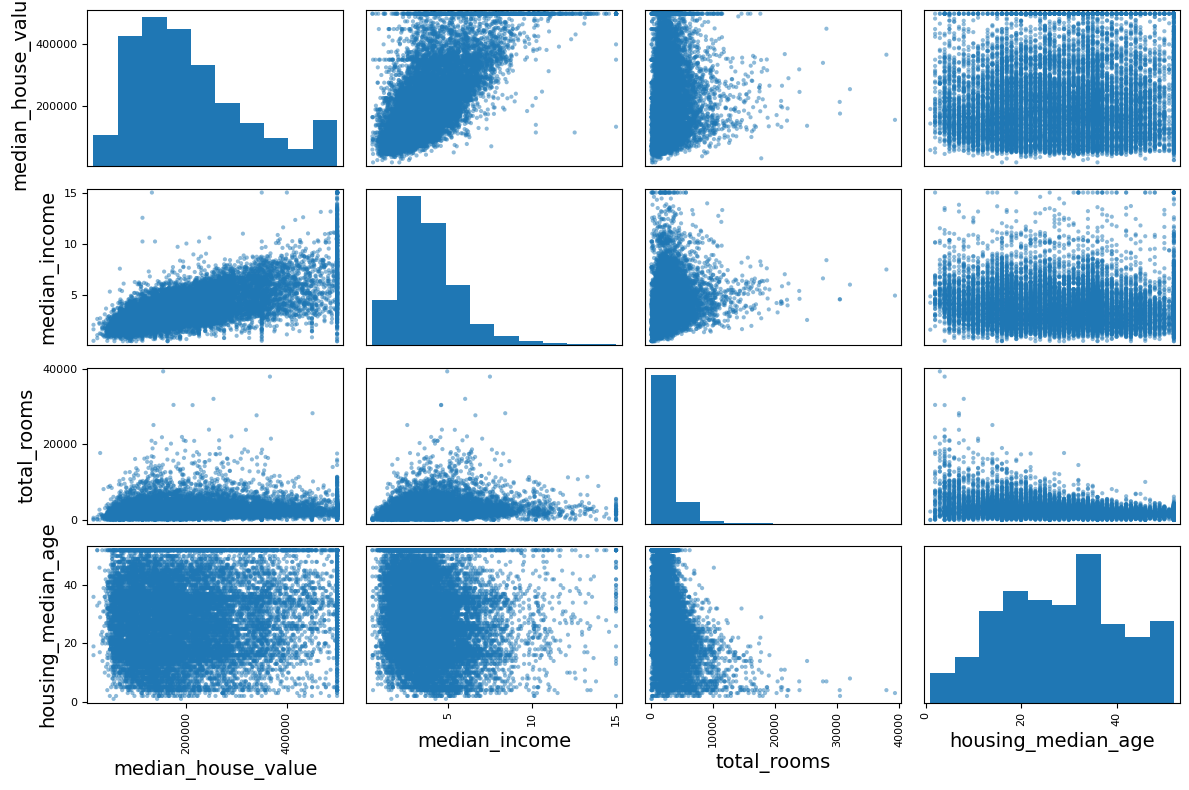

In [8]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix")

# Prepare the Data for Machine Learning Algorithms

In [9]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

using simple_imputer from sklearn

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1) # because it is text attribute
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values
X = imputer.transform(housing_num)

# Handling Text and Categorical Attributes

OrdinalEncoder

In [11]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

OneHotEncoder

In [12]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

# Custom Transformers

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs_pd = pd.DataFrame(housing_extra_attribs)
housing_extra_attribs_pd.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
4,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)


from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model

Training and Evaluating on the Training Set

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
# some_data_prepared = pd.DataFrame(some_data_prepared)
# some_data_prepared
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

# calculate RMSE
# from sklearn.metrics import mean_squared_error
# housing_predictions = lin_reg.predict(housing_prepared)
# lin_mse = mean_squared_error(housing_labels, housing_predictions)
# lin_rmse = np.sqrt(lin_mse)
# lin_rmse

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


## Cross validation

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# cross validation on decision tree regressor
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

# cross validation on linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72403.23019489 70097.36251989 69591.83801045 70129.10617259
 70032.67703964 77961.66810642 71376.99280525 73042.49671023
 68700.35274842 71439.0865952 ]
Mean: 71477.48109029754
Standard deviation: 2498.8183441724586
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


# Fine-Tune Your Model

## Grid Search

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

## Randomized Search

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F6D0B31B10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F6D058E490>},
                   random_state=42, scoring='neg_mean_squared_error')

# Evaluate Your System on the Test Set

In [19]:
from sklearn.metrics import mean_squared_error


final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2
final_rmse

48243.39464155932